# Forecasting beer sales 

github: https://github.com/kohlicekjan/forecasting-beer-sales-ml

### Source
- https://scikit-learn.org/stable/index.html
- https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/
- https://alkaline-ml.com/pmdarima/quickstart.html
- https://facebook.github.io/prophet/

In [82]:
import pandas as pd
import numpy as np
import os
import datetime
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [83]:
DATASET_NAME = 'on-trade'

DATA_PATH = f'./data/{DATASET_NAME}_data.csv'

MODEL_PATH = f'./models/{DATASET_NAME}_model.joblib'

RESULT_CSV_PATH = f'./results/{DATASET_NAME}_result.csv'
RESULT_EXCEL_PATH = f'./results/{DATASET_NAME}_result.xlsx'

In [84]:
data = pd.read_csv(DATA_PATH, header=0, decimal=",", dtype={'SkuShort':'object'})
# data = data.fillna(0)

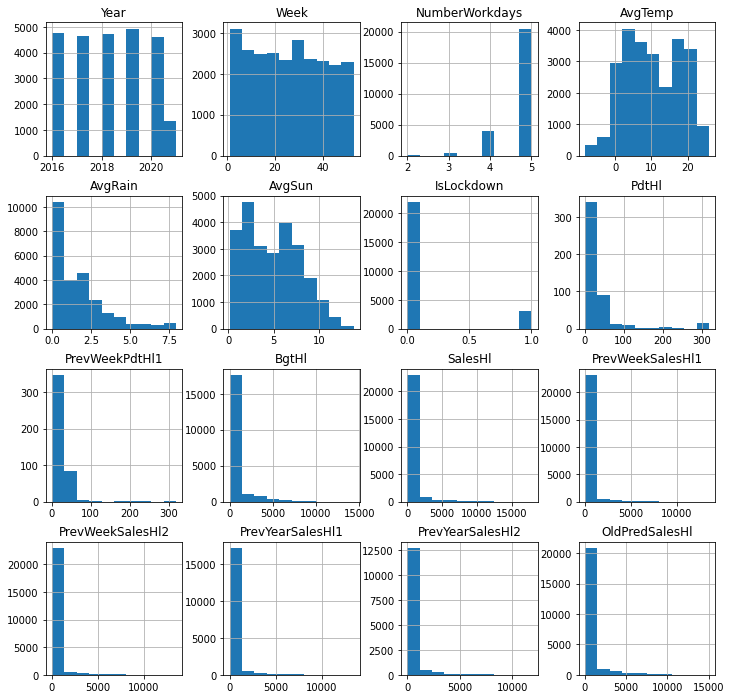

In [85]:
data.hist(figsize=[12,12])
plt.show()

In [86]:
#data = data.set_index(['Year', 'Week'])

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25002 entries, 0 to 25001
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SkuShort          25002 non-null  object 
 1   ProductGroup      25002 non-null  object 
 2   PrimaryPack       25002 non-null  object 
 3   Country           25002 non-null  object 
 4   Year              25002 non-null  int64  
 5   Week              25002 non-null  int64  
 6   NumberWorkdays    25002 non-null  int64  
 7   AvgTemp           25002 non-null  float64
 8   AvgRain           25002 non-null  float64
 9   AvgSun            25002 non-null  float64
 10  IsLockdown        25002 non-null  int64  
 11  PdtHl             479 non-null    float64
 12  PrevWeekPdtHl1    449 non-null    float64
 13  BgtHl             20233 non-null  float64
 14  SalesHl           25002 non-null  float64
 15  PrevWeekSalesHl1  24456 non-null  float64
 16  PrevWeekSalesHl2  24253 non-null  float6

In [88]:
data.describe()

,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
count,25002.000000,25002.000000,25002.000000,25002.000000,25002.000000,25002.000000,25002.000000,479.000000,449.000000,20233.000000,25002.000000,24456.000000,24253.000000,18458.000000,13749.000000,23161.000000
mean,2018.157387,25.786497,4.787257,10.362729,1.676177,4.890909,0.122030,32.313421,20.110566,757.496843,620.624621,377.808018,380.386378,461.394173,420.646117,642.398067
std,1.530272,15.039761,0.494658,7.721815,1.648968,2.984937,0.327327,59.760659,34.993695,1484.212328,1473.285981,943.515589,946.969143,1063.198647,920.020846,1408.082133
min,2016.000000,1.000000,2.000000,-8.278571,0.000000,0.142857,0.000000,0.300000,0.300000,0.000251,0.000000,0.000000,0.000000,0.000000,0.000000,0.053200
25%,2017.000000,13.000000,5.000000,4.000000,0.471429,2.164286,0.000000,3.045784,2.781457,58.403662,30.000000,25.200000,25.800000,36.000000,39.000000,39.999200
50%,2018.000000,25.000000,5.000000,10.178571,1.142857,4.707143,0.000000,13.037634,7.666667,214.440000,121.200000,79.200000,80.000000,108.600000,110.000000,150.470900
75%,2019.000000,39.000000,5.000000,17.707143,2.364286,7.135165,0.000000,33.846154,28.889304,658.311358,486.300000,334.900000,336.910200,418.500000,415.500000,533.663400
max,2021.000000,53.000000,5.000000,25.814286,7.957143,13.864286,1.000000,318.814035,318.814035,14379.048541,17816.500000,13487.500000,13487.500000,13487.500000,11801.000000,15049.836100


<AxesSubplot:xlabel='Year,Week'>

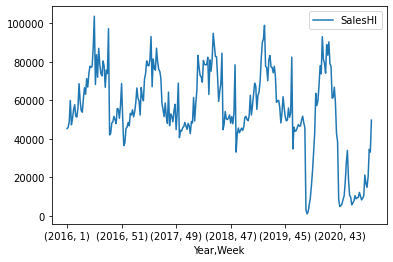

In [89]:
data.groupby(['Year','Week']).sum().plot(y=['SalesHl'])

In [90]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

#data['Date'] = data[['Year','Week']].apply(lambda x : datetime.datetime.strptime(f'{x[0]}-W{x[1]}-1', "%Y-W%W-%w"), axis=1)
#data.Date = data.Date.map(datetime.datetime.toordinal)

#category
data.IsLockdown =  data.IsLockdown.astype('bool')

data.SkuShort = LabelEncoder().fit_transform(data.SkuShort)
data.ProductGroup = LabelEncoder().fit_transform(data.ProductGroup)
data.PrimaryPack = LabelEncoder().fit_transform(data.PrimaryPack)
data.Country = LabelEncoder().fit_transform(data.Country)


data['AvgPrevWeekSalesHl'] = data[['PrevWeekSalesHl1', 'PrevWeekSalesHl2']].fillna(0).mean(axis=1).round(0).astype('int64')
data['AvgPrevYearSalesHl'] = data[['PrevYearSalesHl1', 'PrevYearSalesHl2']].fillna(0).mean(axis=1).round(0).astype('int64')
data['AvgPrevAllSalesHl'] = data[['PrevYearSalesHl1', 'PrevYearSalesHl2', 'PrevWeekSalesHl1', 'PrevWeekSalesHl2']].fillna(0).mean(axis=1).round(0).astype('int64')


#round weather
data.AvgTemp = data.AvgTemp.round(0).astype('int64')
data.AvgRain = data.AvgRain.round(0).astype('int64')
data.AvgSun = data.AvgSun.round(0).astype('int64')

#data = data.drop(['PrevWeekSalesHl1', 'PrevWeekSalesHl2'], axis=1)

# data.at[((data.Year == 2020) & (data.Week == 50)), 'IsLockdown'] = False
# data.at[((data.Year == 2020) & (data.Week == 51)), 'IsLockdown'] = False

data.head()

,SkuShort,ProductGroup,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,...,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl
0,0,1,3,0,2016,1,5,-1,1,1,...,1901.850666,2057.73,NaN,NaN,NaN,NaN,1902.0890,0,0,0
1,1,1,0,0,2016,1,5,-1,1,1,...,472.938882,394.50,NaN,NaN,NaN,NaN,375.6472,0,0,0
2,2,1,0,0,2016,1,5,-1,1,1,...,3010.971784,2535.60,NaN,NaN,NaN,NaN,2311.0085,0,0,0
3,3,1,0,0,2016,1,5,-1,1,1,...,4930.067934,4515.50,NaN,NaN,NaN,NaN,4459.9005,0,0,0
4,5,1,1,0,2016,1,5,-1,1,1,...,46.150597,7.15,NaN,NaN,NaN,NaN,40.8850,0,0,0


In [91]:
train = data[(data.Year <= 2019) | (data.Year == 2021) | ((data.Year == 2020) & (data.Week < 45))]
test = data[(data.Year == 2020) & (data.Week >= 45)]

# train = data[(data.Year <= 2020) | ((data.Year == 2021) & (data.Week < 10))]
# test = data[(data.Year == 2021) & (data.Week >= 10)]

#train = train.append([train[train.IsLockdown == 1]]*2, ignore_index=True)

cols_drop = ['SalesHl', 'OldPredSalesHl', 'BgtHl']
#'SkuShort', 'ProductGroup', 'PrimaryPack', 'Country', 'Year'

y_train = pd.DataFrame(train.SalesHl).round(0).astype(int)
X_train = train.drop(cols_drop, axis=1)

y_test = pd.DataFrame(test.SalesHl).round(0).astype(int)
X_test = test.drop(cols_drop, axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train.head()


y_oldPred = pd.DataFrame(test.OldPredSalesHl).fillna(0).round(0).astype(int)

In [92]:
feature_names = X_train.columns.tolist()

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, FunctionTransformer,  StandardScaler

imp_mean = SimpleImputer(strategy='mean')
imp_mean.fit(X_train)
X_train = imp_mean.transform(X_train)
X_test = imp_mean.transform(X_test)

# ft = FunctionTransformer(np.log1p)
# ft.fit(X_train)
# X_train = ft.transform(X_train)
# X_test = ft.transform(X_test)

scaler = MinMaxScaler() #0.5734, 0.8004
#scaler = MaxAbsScaler() #0.5690, 0.7966
#scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [93]:
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_percentage_error

from sklearn import ensemble, gaussian_process, isotonic, kernel_ridge, linear_model, neighbors, neural_network, svm, tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import TransformedTargetRegressor

# Create linear regression object

#NOT model = ensemble.AdaBoostRegressor()
#tree.DecisionTreeRegressor(random_state=0)
#model = ensemble.BaggingRegressor(base_estimator=svm.SVR(), bootstrap=True, bootstrap_features=False, n_estimators=200, oob_score=False, warm_start=True) # ON-TRADE: ,OFF-TRADE: 0.79
#model = ensemble.ExtraTreesRegressor(n_jobs=3) # ON-TRADE: ,OFF-TRADE: 0.7962
#model = ensemble.GradientBoostingRegressor()
#model = ensemble.RandomForestRegressor(n_estimators=1000, n_jobs=3, bootstrap=True, criterion='mse', oob_score=True) # ON-TRADE: ,OFF-TRADE: 0.7933 
#NOT model = ensemble.StackingRegressor(estimators=[('lgbm', lgb.LGBMRegressor()),('hgb', ensemble.HistGradientBoostingRegressor())],final_estimator=ensemble.BaggingRegressor(), n_jobs=4, passthrough=False) 
#model = ensemble.VotingRegressor([('lgbm', lgb.LGBMRegressor(n_estimators=5000, learning_rate=0.005)), ('rf', ensemble.RandomForestRegressor(n_estimators=1000))]) # ON-TRADE: ,OFF-TRADE: 0.8143
#model = ensemble.HistGradientBoostingRegressor(random_state=1, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False) # ON-TRADE: ,OFF-TRADE: 0.7937 

#NOT model = gaussian_process.GaussianProcessRegressor()
#NOT model = isotonic.IsotonicRegression()

#NOT model = kernel_ridge.KernelRidge(alpha=1.0)# ON-TRADE: ,OFF-TRADE: 0.7827

# #option CV
#model = linear_model.LogisticRegression(max_iter=10)
#model = linear_model.LinearRegression(copy_X=False, fit_intercept=True, normalize=False, positive=False)# ON-TRADE: ,OFF-TRADE: 0.7875
#model = linear_model.Ridge(max_iter=1000, copy_X=False, fit_intercept=True, normalize=True, solver='sparse_cg')# ON-TRADE: ,OFF-TRADE: 0.7876
#model = linear_model.SGDRegressor(max_iter=1500, early_stopping=False, alpha=0.0001, average=True, epsilon=0.1,eta0=0.01, fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling', loss='huber', penalty='l2', power_t=0.1, shuffle=True, warm_start=True) # ON-TRADE: ,OFF-TRADE:  0.7819 

#model = linear_model.ElasticNet(max_iter=2000, alpha=0.001, copy_X=False, fit_intercept=True, l1_ratio=1, normalize=True, positive=False, precompute=False, selection='random', warm_start=True)# ON-TRADE: ,OFF-TRADE: 0.7875
#model = linear_model.Lars(n_nonzero_coefs=1000) # ON-TRADE: , OFF-TRADE: 0.7875 {'copy_X': True, 'fit_intercept': True, 'fit_path': True, 'jitter': False, 'normalize': False, 'precompute': False, 'verbose': True}
#model = linear_model.LassoLars(max_iter=500) # ON-TRADE: , OFF-TRADE: 0.7875 {'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'fit_path': True, 'jitter': False, 'normalize': True, 'positive': False, 'precompute': True, 'verbose': True}
#model = linear_model.OrthogonalMatchingPursuit() # ON-TRADE: , OFF-TRADE: 0.7035 {'fit_intercept': True, 'normalize': True}
#model = linear_model.ARDRegression(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=False) # ON-TRADE: , OFF-TRADE: 0.7875
#model = linear_model.BayesianRidge(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=True) 

#model = linear_model.HuberRegressor(max_iter=500, epsilon=1.6, fit_intercept=True, warm_start=True) # ON-TRADE: , OFF-TRADE: 0.7805
#model = linear_model.RANSACRegressor(max_trials=500) #ON-TRADE: , OFF-TRADE: 0.7225
#model = linear_model.TheilSenRegressor(max_iter=500, n_jobs=-1) # ON-TRADE: , OFF-TRADE: 0.7582 {'copy_X': False, 'fit_intercept': True, 'verbose': True}

#NOT model = linear_model.PoissonRegressor(max_iter=500)
#model = linear_model.TweedieRegressor(max_iter=500, alpha=0.05, fit_intercept=False, link='auto', power=0, warm_start=True) # ON-TRADE: , OFF-TRADE: 0.7871
#NOT model = linear_model.GammaRegressor(max_iter=500) # ON-TRADE: ,OFF-TRADE:
#NOT model = linear_model.PassiveAggressiveRegressor(random_state=0, fit_intercept=True) # ON-TRADE: , OFF-TRADE: 0.6938

#model = neighbors.KNeighborsRegressor(n_neighbors=7, weights='uniform', leaf_size=30, n_jobs=-1) # ON-TRADE: , OFF-TRADE: 0.7941
#NOT model = neighbors.RadiusNeighborsRegressor(radius=5.0, weights='distance')

#NOT model = svm.LinearSVR() # ON-TRADE: , OFF-TRADE: 0.7049




# param_grid = dict()
# #alpha=[1, 0.5, 0.1, 0.05, 0.001, 0.0005, 0.0001],fit_intercept=[True, False], verbose=[True, False], normalize=[True, False], precompute=[True, False], copy_X=[True, False], fit_path=[True, False], positive=[True, False], jitter=[True, False]
# clf = GridSearchCV(model, param_grid, n_jobs=2) #, random_state=0
# search = clf.fit(X_train, y_train.values.ravel())
# #print(search.cv_results_)
# print(search.best_score_)
# print(search.best_params_)


hgbModel = ensemble.HistGradientBoostingRegressor(random_state=0, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False)
mlpModel = neural_network.MLPRegressor(activation='relu', solver='adam', learning_rate='constant', nesterovs_momentum=True, shuffle=False, verbose=False, warm_start=True, random_state=1, hidden_layer_sizes=60, max_iter=1000, early_stopping=False)
rfModel = ensemble.RandomForestRegressor(random_state=0,n_estimators=1000, bootstrap=True, criterion='mse', oob_score=True, n_jobs=3)
# knModel = neighbors.KNeighborsRegressor(n_neighbors=7, weights='uniform', leaf_size=30, n_jobs=-1)
# sgdModel = linear_model.SGDRegressor(max_iter=1500, early_stopping=False, alpha=0.0001, average=True, epsilon=0.1,eta0=0.01, fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling', loss='huber', penalty='l2', power_t=0.1, shuffle=True, warm_start=True)

xgbModel = XGBRegressor(random_state=0, tree_method='approx', booster='dart', n_jobs=3)
# lgbmModel = LGBMRegressor(n_estimators=10000, learning_rate=0.001, num_leaves=300, n_jobs=3)

estimators = [('hgb', hgbModel), ('mlp', mlpModel), ('rf', rfModel), ('xgb', xgbModel)]

model = ensemble.VotingRegressor(estimators, weights=[1, 0.5, 0.5, 0.8], n_jobs=3)


# Train the model using the training sets
model.fit(X_train, y_train.values.ravel())

# Make predictions using the testing set
y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 0

# # The mean squared error
# print('Mean squared error: %.4f'% mean_squared_error(y_test, y_pred))

print(DATASET_NAME)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))

# #Best possible score is 1.0, lower values are worse.
# print('Explained variance regression: %.4f'% explained_variance_score(y_test, y_pred))

#max_error metric calculates the maximum residual error.
print('Maximum residual error: %.4f'% max_error(y_test, y_pred))

# #Mean absolute percentage error regression loss.
# print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_pred))

print('Old Coefficient of determination: %.4f'% r2_score(y_test, y_oldPred))
print('Old Maximum residual error: %.4f'% max_error(y_test, y_oldPred))

# print(f'The number of iterations as selected by early stopping: {model.n_iter_}')
# print(f'The scores at each iteration on the training data: {model.train_score_}')
# print(f'The scores at each iteration on the held-out validation data: {model.validation_score_}')
# print(f'Boolean mask for the categorical features: {model.is_categorical_}')

#on-trade
#LGBMRegressor = 0.2801, 0.7314
#MLPRegressor = 0.1532, 0.2210
#VotingRegressor = 0.5829, 0.8377
#HistGradientBoostingRegressor = 0.4634, 0.8241
#RandomForestRegressor = 0.4809, 0.7280

#off-trade
#LGBMRegressor = , 0.8537
#MLPRegressor = 0.7418, 0.7768
#VotingRegressor = 0.8442, 0.8572
#HistGradientBoostingRegressor = 0.8640, 0.8470
#RandomForestRegressor = 0.8557, 0.8418

on-trade
Coefficient of determination: 0.6246
Maximum residual error: 3429.3456
Old Coefficient of determination: 0.4995
Old Maximum residual error: 2890.0000


In [94]:
def get_percentage_diff(previous, current):
    return 1 - (abs(previous - current)/max(previous, current))

result = test.copy(deep=False)
result["PredictSalesHl"] = y_pred

resultWeek = result.groupby(['Year','Week']).sum()
resultWeek = resultWeek[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
resultWeek['NewPredSalesHlDiff'] = resultWeek.NewPredSalesHl-resultWeek.OldPredSalesHl
resultWeek = (100. * resultWeek).round(1).astype(str) + '%'
print(resultWeek)

resultYear = result.groupby(['Year']).sum()
resultYear= resultYear[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
resultYear['NewPredSalesHlDiff'] = resultYear.NewPredSalesHl-resultYear.OldPredSalesHl
resultYear = (100. * resultYear).round(1).astype(str) + '%'
print(resultYear)

# resultSkuShort = result.groupby(['SkuShort']).sum()
# resultSkuShort = resultSkuShort[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
# resultSkuShort['NewPredSalesHlDiff'] = resultSkuShort.NewPredSalesHl-resultSkuShort.OldPredSalesHl
# resultSkuShort = (100. * resultSkuShort).round(1).astype(str) + '%'

# print(resultSkuShort)

          OldPredSalesHl NewPredSalesHl NewPredSalesHlDiff
Year Week                                                 
2020 45            68.8%          67.7%              -1.2%
     46            53.2%          78.6%              25.4%
     47            58.7%          68.8%              10.1%
     48            44.3%          89.3%              44.9%
     49            40.4%          54.9%              14.6%
     50            60.5%          46.9%             -13.6%
     51            49.9%          78.2%              28.2%
     52            62.7%          74.8%              12.1%
     53            87.0%          89.8%               2.8%
     OldPredSalesHl NewPredSalesHl NewPredSalesHlDiff
Year                                                 
2020          76.8%          85.5%               8.7%


## Model analysis

In [95]:
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)


# forest_importances = pd.Series(result.importances_mean, index=feature_names)

# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
# ax.set_title("Feature importances using permutation on full model")
# ax.set_ylabel("Mean accuracy decrease")
# fig.tight_layout()
# plt.show()

In [96]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel


examples_numpy = pd.concat([pd.DataFrame(X_train).sample(n=50), pd.DataFrame(X_test).sample(n=50)]).to_numpy()

# wrap our base model with InMemoryModel instance
annotated_model = InMemoryModel(
    model.predict, 
    examples = examples_numpy, 
    model_type = 'regressor'
)

interpreter = Interpretation(examples_numpy, feature_names=feature_names)

2021-05-28 17:05:12,789 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

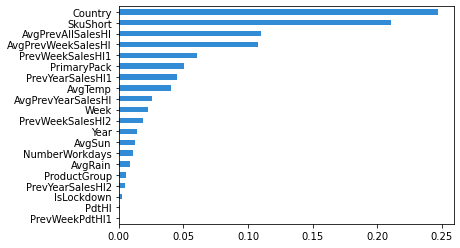

In [97]:
interpreter.feature_importance.plot_feature_importance(annotated_model, progressbar=False)

In [98]:
# interpreter.partial_dependence.plot_partial_dependence(
#     feature_names, annotated_model, grid_resolution=20, progressbar=False
# )

In [99]:
# from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

# # create an explainer
# explainer = LimeTabularExplainer(examples_numpy, feature_names=feature_names, mode="regression")

# # explain something
# explanation = explainer.explain_instance(examples_numpy[5], annotated_model)

# # show the explanation
# explanation.show_in_notebook()

In [100]:
# import shap
# #shap.initjs()

# X100 = shap.utils.sample(train, 100)

# explainer = shap.Explainer(model)
# shap_values = explainer(X100)

# shap.plots.waterfall(shap_values[0])

In [101]:
# shap.plots.force(shap_values[0])

In [102]:
# shap.plots.force(shap_values)

In [103]:
# shap.plots.scatter(shap_values, color=shap_values)

In [104]:
# shap.plots.bar(shap_values)

In [105]:
# shap.plots.beeswarm(shap_values)

## Save Result

In [106]:
result = test.copy(deep=False)
result["PredictSalesHl"] = y_pred

dir_path = os.path.dirname(RESULT_CSV_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)
 
result.to_csv(RESULT_CSV_PATH, index=False)
result.to_excel(RESULT_EXCEL_PATH, index=False)

## Save model

In [107]:
import joblib

dir_path = os.path.dirname(MODEL_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)

joblib.dump(model, MODEL_PATH, compress=True)

['./models/on-trade_model.joblib']

## Use model

In [108]:
# import joblib
# import os
# import numpy as np

# file = open(MODEL_PATH, 'rb')

# model = joblib.load(file)

# SkuShort = 2605
# Week = 23
# NumberWorkdays = 5
# AvgTemp = 15.892857142857142
# AvgRain = 3.5000000000000004
# AvgSun = 6.735714285714286
# IsLockdown = 0
# PdtHl = -1.0
# PrevWeekPdtHl1 = -1.0
# BgtHl = 6665
# PrevWeekBgtHl1 = 6665.949490847161
# PrevWeekSalesHl1 = 5020
# PrevWeekSalesHl2 = 5038
# SalesHl = 5386.5

# x = np.array([[SkuShort, Week,NumberWorkdays, AvgTemp, AvgRain, AvgSun, IsLockdown, PdtHl, PrevWeekPdtHl1, BgtHl, PrevWeekBgtHl1, PrevWeekSalesHl1, PrevWeekSalesHl2]])

# y_pred = model.predict(x)
# result = y_pred[0]

# def get_percentage_diff(previous, current):
#     return 1 - (abs(previous - current)/max(previous, current))

# print('Forecast sales: %.4f hl'% result)
# print('Coefficient of determination: %.4f'% get_percentage_diff(SalesHl, result))

#full with sku = 0.7678
#full = 0.7363